<center><h1> Cleaning Data</h1></center>
***

Missing data can be of different types:

* **Missing Completely at Random (MCAR)** - the propensity for a data point to be missing is completely random.
* **Missing at Random (MAR)** - means  the propensity for a data point to be missing is not related to the missing data, but it is related to some of the observed data.
* **Missing Not at Random (MNAR)** - when the missing values on a variable are related to the values of that variable itself, even after controlling for other variable

In our dataset we might have Missing Completely at Random variables and Missing at Random variables, but luckily no Missing Not at Random values. I suppose columns representing color, fuel and model are Missing Completely at Random. So since these variables are categorical, I don't want to drop them, because this will decrease my dataset, so I will fill the NaN values of this columns by value meaning 'other'. I think that some of these missing values might have meant, that there were no approproate choice, so there were not selected.   
I will drop values of year, capacity - because this columns are important, and I don't want to introduce bias in my dataset. And also I will drop the NaN values of transmission, carcass, wheel and drive, because these columns don't really have a lot of missing values.  
With regard to column that represent mileage, I will show that this column is Missing at Random column, and it can be succefully imputed via imputation techniques.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import set_jupyter_path
from src.car_price_prediction.utils import dataset_manager, df_utils

In [4]:
data = dataset_manager.get_cleaned_outliers_dataset()

And what I do right away is, I create a new dataset, where I show how many percent of the cars don't have a filled mileage column and I do that grouping cars by their year.

In [13]:
nulldataset= data[~data.Mileage.notnull()]["Year"]
totaldataset = data.Year
nullval = nulldataset.value_counts()
totalval = totaldataset.value_counts()
percentage = 100.0/totalval*nullval

nan_mileage =  pd.DataFrame({"All cars":totalval,"Cars with NaN":nullval,"percentage":percentage})


You can see yourself that people tend to not specify the mileage of the car, when the car is older in the plot. There are several outliers, but we can clearly see the trend here.

Text(0,0.5,'Percentage')

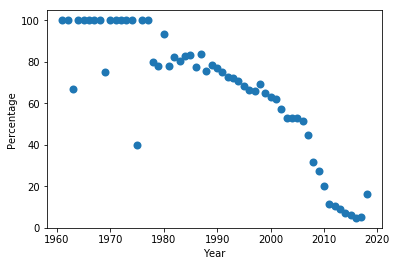

In [15]:
plt.scatter(df.index,percentage,marker="o",linewidths=2)
plt.xlabel("Year")
plt.ylabel("Percentage")

So here is the problem, I can not impute any of the missing values in the dataset by median, mean or mode, because it will definetely create bias in the model. So, I need to use more sophisticated ways of imputing, but unfortunately in scikit-learn there is no convinient library for doing so, there is a library called "fancyimpute", but since this library immature, it is very hard to implement and even install.
So, the solution will be to manually impute the values. 

I created three datasets, with which I will work in next notebook dropped_data (where I dropped all the values), Imputed data (where I imputed all the values) and maximum unbiased dataset, I tried to create this dataset using my filed knowledge. And here is what I did, when trying to create this maximum unbiased dataset:
* Some columns with missing categorical feauteres, I made as a one different class.
* Other columns, when there was no meaning in making a different class for missing values, I just dropped.
* I imputed just mileage column.
* And other missing continious features, I dropped.

So, in the next notebook, I will approximate the error of each dataset and choose which data is most appropriate to work with.